# RQ1 — Evaluating Household Tariffs on ResStock MA Sample

**Research Question 1 (RQ1)**  
How do different retail electricity tariff structures (e.g., flat rate, time-of-use, real-time pricing proxy) affect:
- total annual bills for households, and  
- the distribution of costs across households with different characteristics  
in a realistic sample of Massachusetts residential load profiles?

This notebook:
1. Loads a sample of individual-building 15-minute load profiles from the NREL ResStock AMY2018 dataset (MA, upgrade 0 / baseline).  
2. Loads the corresponding building-level metadata and dictionary files.  
3. Runs sanity checks to confirm we have the right data to evaluate RQ1 before scaling to the full dataset.  

In [204]:
from pathlib import Path
import sys
print(sys.executable)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10, 4)

# Make sure we can import loadOEDIData.py from aidms-final-project
project_dir = Path("aidms-final-project").resolve()
if str(project_dir) not in sys.path:
    sys.path.append(str(project_dir))

from loadOEDIData import load_all, load_timeseries_for_buildings

print("Python executable:", sys.executable)
print("Project dir:", project_dir)


/Users/cristinechen/Desktop/AIDMS/aidms-final-project/aidms_venv/bin/python
Python executable: /Users/cristinechen/Desktop/AIDMS/aidms-final-project/aidms_venv/bin/python
Project dir: /Users/cristinechen/Desktop/AIDMS/aidms-final-project/aidms-final-project


## Data sources and formats

We use a local mirror of the NREL **ResStock AMY2018** dataset:

- **Source:** `oedi-data-lake/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2025/resstock_amy2018_release_1`
- **Local root:** `../OEDIDataset/`

Within `OEDIDataset`:

- `*.parquet` — Individual-building 15-minute timeseries for **baseline** (`upgrade_id = 0`) buildings in Massachusetts.  
  - Columns include `bldg_id`, `timestamp`, `in.sqft`, and multiple `out.electricity.*.energy_consumption..kwh` end-use columns.
- `metadata/upgrade0.parquet` — Building-level characteristics and annual results for all baseline buildings (nationwide).
- `dictionaries/`
  - `data_dictionary.tsv` — Descriptions of all `in.*` and `out.*` fields.
  - `enumeration_dictionary.tsv` — Expansion of categorical codes (e.g., region, tenure).
- `timeseries_aggregates/by_state/state=MA/*.csv` — MA-level aggregate load profiles by building type (used for sanity checks).

This notebook **only** touches whichever building timeseries files are present in `OEDIDataset` (e.g., the initial 1000 MA buildings, or more if added later).


In [205]:
# Load all preprocessed pieces via helper module
all_data = load_all()

meta = all_data["metadata"]                      # building-level metadata (nationwide)
data_dict = all_data["data_dictionary"]          # column descriptions
enum_dict = all_data["enumeration_dictionary"]   # enumeration descriptions
ts_index = all_data["timeseries_index"]          # index of local building timeseries files
agg_ma = all_data["state_aggregates"]            # MA state-level aggregates (if present)

print("Metadata shape:", None if meta is None else meta.shape)
print("Timeseries files (local):", len(ts_index))
print("Data dictionary:", None if data_dict is None else data_dict.shape)
print("Enumeration dictionary:", None if enum_dict is None else enum_dict.shape)
print("MA aggregates:", None if agg_ma is None else agg_ma.shape)

# Restrict metadata to the buildings we actually downloaded timeseries for
if meta is not None:
    bldg_ids = ts_index["building_id"].unique()
    meta_sample = meta[meta["bldg_id"].isin(bldg_ids)].copy()
    print("Metadata rows for local timeseries buildings:", len(meta_sample))
else:
    meta_sample = None


=== Loading OEDI dataset pieces ===
[load_metadata] Reading upgrade0.parquet ...
[load_metadata] Combined metadata shape: (549971, 771)
[load_dictionaries] Reading data_dictionary.tsv ...
[load_dictionaries] data_dictionary shape: (841, 5)
[load_dictionaries] Reading enumeration_dictionary.tsv ...
[load_dictionaries] UTF-8 decode failed, retrying with latin-1 ...
[load_dictionaries] enumeration_dictionary shape: (58457, 3)
[build_timeseries_index] Searching 100 parquet files under /Users/cristinechen/Desktop/AIDMS/OEDIDataset/timeseries_individual/by_state (recursive)
[build_timeseries_index] Found timeseries files: 100
[load_state_aggregates] Reading up00-ma-mobile_home.csv ...
[load_state_aggregates] Reading up00-ma-multi-family_with_2_-_4_units.csv ...
[load_state_aggregates] Reading up00-ma-multi-family_with_5plus_units.csv ...
[load_state_aggregates] Reading up00-ma-single-family_attached.csv ...
[load_state_aggregates] Reading up00-ma-single-family_detached.csv ...
[load_state_ag

## Sanity checks before using this sample for RQ1

Before designing tariffs and computing bills, we want to confirm:

1. **Timeseries coverage**  
   - Each building has full-year 15-minute data (no large gaps).  
   - We can compute total kWh per 15-min step by summing end-use columns.

2. **Metadata alignment**  
   - Every building with timeseries has a matching metadata row.  
   - We have key fairness-relevant attributes: income proxy, building type, tenure, region/county.

3. **Reasonable consumption levels**  
   - Annual kWh per building is in a plausible range.  
   - Aggregate behavior roughly matches MA state aggregates.

We’ll do lightweight checks using a subset of buildings (e.g., up to 50), but code is written to adapt to any number of local parquet files.


In [206]:
# Choose how many buildings to use for sanity checks
N_SAMPLE_BUILDINGS = 100

n_available = len(ts_index)
n_use = min(N_SAMPLE_BUILDINGS, n_available)
print(f"Using {n_use} / {n_available} buildings for timeseries sanity checks")

# Randomly sample buildings from the index (so we don't always take the first N)
ts_index_sample = ts_index.sample(n=n_use, random_state=0).reset_index(drop=True)

# Load timeseries for the sampled buildings
ts_sample = load_timeseries_for_buildings(ts_index_sample, n_files=n_use)

print("ts_sample shape:", ts_sample.shape)

# Identify electricity end-use columns
elec_cols = [
    c for c in ts_sample.columns
    if c.startswith("out.electricity.")
    and c.endswith(".energy_consumption..kwh")
]
print("Number of electricity end-use columns:", len(elec_cols))
# Total whole-house electricity kWh per 15-min interval
ts_sample["kwh_total"] = ts_sample[elec_cols].sum(axis=1)

ts_sample[["bldg_id", "timestamp", "kwh_total"]].head()

Using 100 / 100 buildings for timeseries sanity checks
[load_timeseries_for_buildings] Reading 101365-0.parquet ...
[load_timeseries_for_buildings] Reading 103571-0.parquet ...
[load_timeseries_for_buildings] Reading 100158-0.parquet ...
[load_timeseries_for_buildings] Reading 102585-0.parquet ...
[load_timeseries_for_buildings] Reading 103364-0.parquet ...
[load_timeseries_for_buildings] Reading 104042-0.parquet ...
[load_timeseries_for_buildings] Reading 100696-0.parquet ...
[load_timeseries_for_buildings] Reading 103316-0.parquet ...
[load_timeseries_for_buildings] Reading 102315-0.parquet ...
[load_timeseries_for_buildings] Reading 104139-0.parquet ...
[load_timeseries_for_buildings] Reading 102286-0.parquet ...
[load_timeseries_for_buildings] Reading 104006-0.parquet ...
[load_timeseries_for_buildings] Reading 103391-0.parquet ...
[load_timeseries_for_buildings] Reading 100602-0.parquet ...
[load_timeseries_for_buildings] Reading 100325-0.parquet ...
[load_timeseries_for_buildings

,bldg_id,timestamp,kwh_total
0,101365,2018-01-01 00:15:00,0.27924
1,101365,2018-01-01 00:30:00,0.24439
2,101365,2018-01-01 00:45:00,0.23824
3,101365,2018-01-01 01:00:00,0.23722
4,101365,2018-01-01 01:15:00,0.23567


In [207]:
print(ts_sample.filter(like='income').columns)

Index([], dtype='object')


Annual kWh from timeseries (sample):


,bldg_id,annual_kwh_ts
count,100.000000,100.000000
mean,96659.070000,24565.347656
std,22400.063673,18932.763672
min,1022.000000,1079.192017
25%,101182.000000,12904.020264
50%,101921.500000,19873.547852
75%,103325.750000,31545.339844
max,104258.000000,121652.367188


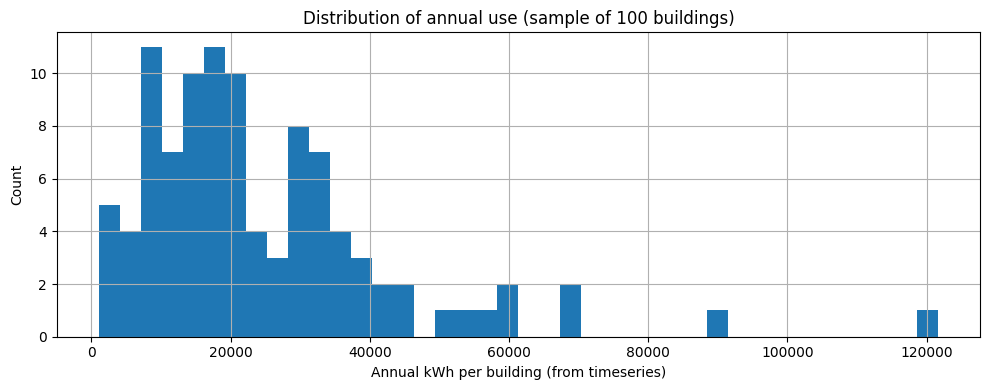

In [208]:
# Annual kWh per building from timeseries
annual_kwh_ts = (
    ts_sample.groupby("bldg_id")["kwh_total"]
    .sum()
    .reset_index(name="annual_kwh_ts")
)

print("Annual kWh from timeseries (sample):")
display(annual_kwh_ts.describe())

# Histogram
plt.figure()
annual_kwh_ts["annual_kwh_ts"].hist(bins=40)
plt.xlabel("Annual kWh per building (from timeseries)")
plt.ylabel("Count")
plt.title(f"Distribution of annual use (sample of {n_use} buildings)")
plt.tight_layout()
plt.show()

In [233]:
# sample columns to display from metadata
candidate_cols = ["in.puma_metro_status"]

if meta_sample is not None:
    meta_for_sample = meta_sample.merge(
        annual_kwh_ts, left_on="bldg_id", right_on="bldg_id", how="inner"
    )
    print("Joined metadata + annual kWh shape:", meta_for_sample.shape)
    existing_cols = [c for c in candidate_cols if c in meta_for_sample.columns]
    print(list(meta_for_sample[candidate_cols[0]].unique()))
else:
    meta_for_sample = None
    print("No metadata loaded; cannot join.")


Joined metadata + annual kWh shape: (100, 772)
['In metro area, not/partially in principal city', 'Not/partially in metro area', 'In metro area, principal city']


In [234]:
if meta_for_sample is not None:
    for col in ["in.representative_income", "in.building_type_recs", "in.tenure"]:
        if col in meta_for_sample.columns:
            print(f"\n=== {col} ===")
            print(meta_for_sample[col].value_counts(dropna=False).head(20))
else:
    print("meta_for_sample is None; skipping feature coverage checks.")


=== in.representative_income ===
in.representative_income
NaN         9
6279.0      2
292942.0    2
10949.0     2
38644.0     2
92529.0     1
127278.0    1
75963.0     1
62629.0     1
8081.0      1
38473.0     1
109133.0    1
87078.0     1
45760.0     1
42909.0     1
54851.0     1
63118.0     1
26688.0     1
85423.0     1
108793.0    1
Name: count, dtype: int64

=== in.tenure ===
in.tenure
Owner            55
Renter           36
Not Available     9
Name: count, dtype: int64


In [211]:
if meta_for_sample is not None:
    geo_cols = [c for c in ["in.county_name", "in.ahs_region"] if c in meta_for_sample.columns]
    if geo_cols:
        print("County/region counts (top 20):")
        print(meta_for_sample[geo_cols].value_counts().head(20))
    else:
        print("No county/region columns detected in metadata.")
else:
    print("meta_for_sample is None; skipping geography checks.")

County/region counts (top 20):
in.county_name     in.ahs_region                      
Middlesex County   CBSA Boston-Cambridge-Newton, MA-NH    22
Essex County       CBSA Boston-Cambridge-Newton, MA-NH    13
Worcester County   Non-CBSA New England                   12
Plymouth County    CBSA Boston-Cambridge-Newton, MA-NH    10
Suffolk County     CBSA Boston-Cambridge-Newton, MA-NH    10
Norfolk County     CBSA Boston-Cambridge-Newton, MA-NH     8
Hampshire County   Non-CBSA New England                    7
Bristol County     Non-CBSA New England                    6
Barnstable County  Non-CBSA New England                    4
Berkshire County   Non-CBSA New England                    4
Hampden County     Non-CBSA New England                    3
Dukes County       Non-CBSA New England                    1
Name: count, dtype: int64


Example buildings: [100208, 102901, 100158]


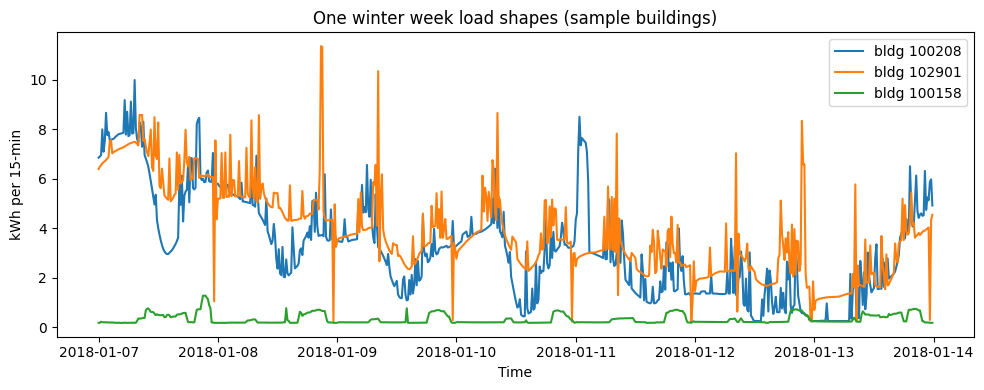

In [212]:
# Convert timestamp and choose 3 buildings
ts_sample["timestamp"] = pd.to_datetime(ts_sample["timestamp"])
bldg_ids_example = ts_sample["bldg_id"].drop_duplicates().sample(
    min(3, ts_sample["bldg_id"].nunique()),
    random_state=0,
).tolist()
print("Example buildings:", bldg_ids_example)

    
week_mask = (ts_sample["timestamp"] >= "2018-01-07") & (ts_sample["timestamp"] < "2018-01-14")
week_ts = ts_sample[week_mask & ts_sample["bldg_id"].isin(bldg_ids_example)]

plt.figure(figsize=(10, 4))
for b in bldg_ids_example:
    b_ts = week_ts[week_ts["bldg_id"] == b]
    plt.plot(b_ts["timestamp"], b_ts["kwh_total"], label=f"bldg {b}")

plt.xlabel("Time")
plt.ylabel("kWh per 15-min")
plt.title("One winter week load shapes (sample buildings)")
plt.legend()
plt.tight_layout()
plt.show()


## Tariff models and where to define them

For RQ1 we want to compare **multiple tariff structures** (e.g., flat, TOU, dynamic/RTP proxy)
on the **same set of household load profiles**.

We will structure this in two layers:

1. **Tariff pricing functions** (one per tariff)  
   Each takes timestamps (and optionally metadata) and returns a per-interval price in \$/kWh.  
   These can be simple (hard-coded flat rate) or complex (look up prices from an external
   dataset that teammates are familiar with).

2. **Generic bill calculator**  
   Given a timeseries DataFrame with `bldg_id`, `timestamp`, and `kwh_total`, plus a pricing
   function, compute:
   - `annual_kwh`
   - `annual_cost_<tariff_name>` per building

This design lets us swap in different pricing datasets or tariff logic **without changing the rest of the notebook**.

In [239]:
# === TARIFF PRICING HOOKS ===
# These functions turn timestamps (and optionally metadata) into a price (in $/kWh)
# for each 15-minute interval.
from random import shuffle

def price_flat(ts_df: pd.DataFrame,
               meta_df: pd.DataFrame | None = None,
               base_rate: float = 0.119387342) -> pd.Series:
  """
  Simple flat tariff: every kWh is charged at the same rate.

  Parameters
  ----------
  ts_df : DataFrame
      Must contain 'timestamp' and 'bldg_id' and 'kwh_total'.
  meta_df : DataFrame or None
      Not used in the simple version, but can be used if we ever want
      region- or customer-specific flat rates.
  base_rate : float
      Flat rate in $/kWh.

  Returns
  -------
  Series of length len(ts_df) with the price for each row (interval).
  """

  time_windows = [
    ("2018-01-01", "2018-04-30", .12673),  # Jan 1–Jan 13
    ("2018-05-01", "2018-10-31", .10870),  # Jan 14–Jan 31
    ("2018-11-01", "2018-12-31", .13718)   # Feb 1–Feb 28
  ]

  price_series = pd.Series(0, index=ts_df.index, dtype=float)

  for start, end, rate in time_windows:
    mask = (ts_df["timestamp"] >= start) & (ts_df["timestamp"] < end)
    price_series.loc[mask] = rate

  return price_series


def price_tou_simple(ts_df: pd.DataFrame,
                     meta_df: pd.DataFrame | None = None,
                     offpeak_rate: float=0.0991,
                     peak_rate: float=0.1211,
                     peak_hours: tuple[int, int]=(8, 20),
                     conservation_rate=0.6137,
                     conservation_hours=8,
                     random_seed: int=100) -> pd.Series:
  """
  Simple Time-of-Use tariff example:
    - peak hours: from peak_hours[0] (inclusive) to peak_hours[1] (exclusive)
    - all other hours are off-peak.

  Assumes ts_df['timestamp'] is in local time (or close enough).

  Teammates could replace this with a more realistic TOU function that
  uses an external dataset or season/weekend distinctions.
  """

  hours = ts_df["timestamp"].dt.hour
  is_weekend = ts_df["timestamp"].dt.weekday >= 5  # Saturday=5, Sunday=6
  start, end = peak_hours

  is_peak = (hours >= start) & (hours < end) & (~is_weekend) 

  prices = np.where(is_peak, peak_rate, offpeak_rate)

  n_intervals = int(np.round(conservation_hours * 4))

  peak_indices = np.where(is_peak)[0]  # get indices of valid peak intervals

  peak_set = set(peak_indices)
  max_start = len(prices) - n_intervals

  # possible_starts: candidate start indices where the whole block is inside peak_set
  possible_starts = [
    s for s in range(0, max_start + 1)
    if all((s + k) in peak_set for k in range(n_intervals))]

  # Shuffle for randomness and pick non-overlapping by stepping through shuffled starts
  rng = np.random.default_rng(random_seed)
  rng.shuffle(possible_starts)

  num_trials = 30

  used = set()
  placed = 0
  
  for s in possible_starts:

    if placed >= num_trials:
      break

    block = range(s, s + n_intervals)

    if any(i in used for i in block):
      continue

    prices[s : s + n_intervals] = conservation_rate
    used.update(block)
    placed += 1

  return pd.Series(prices, index=ts_df.index)


def price_dynamic_stub(ts_df: pd.DataFrame,
                       rtp_csv: str = "RT_LMP_kWh.csv",
                       meta_df: pd.DataFrame | None = None) -> pd.Series:
  """
  Stub for a more complex 'dynamic' / RTP-like tariff.

  This is just a placeholder that currently behaves like a flat rate.
  Teammates can later implement this by:
    - loading a time-indexed price dataset (e.g. hourly RTP),
    - mapping each timestamp in ts_df to the appropriate price,
    - possibly conditioning on region (meta_df).

  For now, we just return a constant so the rest of the pipeline works.
  """
  rtp_df = pd.read_csv(rtp_csv, parse_dates=["timestamp"])
  rtp_df = rtp_df.set_index("timestamp").resample("15min").ffill()
  rtp_aligned = rtp_df.reindex(ts_df["timestamp"], method="ffill")["RT_LMP_kWh"]

  return pd.Series(rtp_aligned.values, index=ts_df.index)

In [240]:
# === GENERIC BILL CALCULATION HELPERS ===

def apply_tariff(ts_df: pd.DataFrame,
                 price_func,
                 meta_df: pd.DataFrame | None = None,
                 tariff_name: str = "tariff") -> pd.DataFrame:
    """
    Apply a tariff pricing function to a load timeseries and compute annual bills.

    Parameters
    ----------
    ts_df : DataFrame
        Must contain at least:
          - 'bldg_id': building identifier
          - 'timestamp': datetime
          - 'kwh_total': total kWh in each 15-min interval
    price_func : callable
        Function with signature price_func(ts_df, meta_df=None, **kwargs)
        returning a Series of per-interval prices in $/kWh.
    meta_df : DataFrame or None
        Optional building-level metadata to pass into the pricing function.
        If used, meta_df should have a 'bldg_id' column.
    tariff_name : str
        Name of the tariff, used to label the 'annual_cost_<tariff_name>' column.

    Returns
    -------
    DataFrame with columns:
      - bldg_id
      - annual_kwh
      - annual_cost_<tariff_name>
    """
    df = ts_df.copy()
    
    # Compute price for each interval
    price_series = price_func(df, meta_df=meta_df)
    df[f"price_{tariff_name}"] = price_series

    # Cost per interval
    df[f"cost_{tariff_name}_interval"] = df["kwh_total"] * df[f"price_{tariff_name}"]

    # Aggregate to annual per building
    annual = (
        df.groupby("bldg_id")
        .agg(
            annual_kwh=("kwh_total", "sum"),
            **{f"annual_cost_{tariff_name}": (f"cost_{tariff_name}_interval", "sum")},
        )
        .reset_index()
    )

    return annual


def apply_all_tariffs(ts_df: pd.DataFrame,
                      meta_df: pd.DataFrame | None = None) -> pd.DataFrame:
    """
    Apply the set of tariffs we are studying (flat, TOU, dynamic stub)
    and return a single DataFrame with one row per building and
    one column per tariff's annual cost.

    This is the main object we will use for RQ1 analysis.
    """
    # Flat tariff
    flat = apply_tariff(ts_df, price_flat, meta_df=meta_df, tariff_name="flat")

    # TOU tariff (simple example for now)
    tou = apply_tariff(ts_df, price_tou_simple, meta_df=meta_df, tariff_name="tou")

    # Dynamic / RTP-like stub
    dyn = apply_tariff(ts_df, price_dynamic_stub, meta_df=meta_df, tariff_name="dynamic")

    # Merge on bldg_id
    merged = flat.merge(tou, on=["bldg_id", "annual_kwh"], how="inner")
    merged = merged.merge(dyn, on=["bldg_id", "annual_kwh"], how="inner")

    return merged

# === CHUNKED BILL COMPUTATION (works for 1k or 11k buildings) ===

def compute_bills_chunked(
    ts_index: pd.DataFrame,
    elec_cols: list[str],
    meta_df: pd.DataFrame | None = None,
    chunk_size: int = 100,
) -> pd.DataFrame:
    """
    Compute annual bills under all tariffs by processing buildings in chunks.

    Parameters
    ----------
    ts_index : DataFrame
        Output of build_timeseries_index(), with at least:
          - 'building_id'
          - 'upgrade_id'
          - 'file_path'
    elec_cols : list of str
        Names of electricity end-use columns to sum into kwh_total.
        (You already computed this from ts_sample.)
    meta_df : DataFrame or None
        Optional building-level metadata (with 'bldg_id') to pass to tariffs.
        NOTE: current price_* functions ignore it, but this keeps the hook.
    chunk_size : int
        How many buildings to process at a time.

    Returns
    -------
    DataFrame with one row per building:
        - bldg_id
        - annual_kwh
        - annual_cost_flat
        - annual_cost_tou
        - annual_cost_dynamic
    """
    n = len(ts_index)
    all_chunks = []

    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        sub_idx = ts_index.iloc[start:end]

        print(f"[compute_bills_chunked] Buildings {start}–{end - 1} of {n}...")

        # Load timeseries for this chunk of buildings
        ts_chunk = load_timeseries_for_buildings(sub_idx, n_files=None)
        if ts_chunk.empty:
            continue

        # Ensure timestamp is datetime
        ts_chunk["timestamp"] = pd.to_datetime(ts_chunk["timestamp"])

        # Total whole-house kWh per interval
        ts_chunk["kwh_total"] = ts_chunk[elec_cols].sum(axis=1)

        # Apply all tariffs to this chunk
        bills_chunk = apply_all_tariffs(ts_chunk, meta_df=meta_df)

        all_chunks.append(bills_chunk)

        # Free memory from this chunk ASAP
        del ts_chunk, bills_chunk

    if not all_chunks:
        print("[compute_bills_chunked] No chunks produced; returning empty DataFrame.")
        return pd.DataFrame()

    bills_all = pd.concat(all_chunks, ignore_index=True)
    return bills_all


In [241]:
# === BILL COMPUTATION: sample vs full-chunked ===

USE_FULL_CHUNKED = False      # <--- flip to False if you only want the small sample
CHUNK_SIZE = 100             # Tune based on your RAM; 50–200 is reasonable

if not USE_FULL_CHUNKED:
    # ----- Original sample-based version (fast, lightweight) -----
    print("Computing bills on SAMPLE only...")
    bills_sample = apply_all_tariffs(ts_sample, meta_df=meta_sample)
    print("bills_sample shape:", bills_sample.shape)
    display(bills_sample.head())

    if meta_sample is not None:
        bills_with_meta = meta_sample.merge(bills_sample, on="bldg_id", how="inner")
        print("bills_with_meta shape:", bills_with_meta.shape)
    else:
        bills_with_meta = None
        print("No metadata available; cannot attach attributes.")

else:
    # ----- New: full MA (or full local) dataset via chunked processing -----

    # Optional: if you want to free RAM before doing the big loop, uncomment:
    # del ts_sample
    # import gc; gc.collect()

    print(f"Computing bills on FULL dataset ({len(ts_index)} buildings) in chunks of {CHUNK_SIZE}...")

    # meta_sample contains metadata only for buildings we have locally,
    # so it's the right thing to pass in (and join against).
    bills_all = compute_bills_chunked(
        ts_index=ts_index,
        elec_cols=elec_cols,
        meta_df=meta_sample,      # currently not used inside price_* funcs
        chunk_size=CHUNK_SIZE,
    )
    print("bills_all shape:", bills_all.shape)
    display(bills_all.head())

    # Join with metadata to get fairness-relevant attributes
    if meta_sample is not None:
        bills_with_meta = meta_sample.merge(bills_all, on="bldg_id", how="inner")
        print("bills_with_meta shape:", bills_with_meta.shape)
    else:
        bills_with_meta = None
        print("No metadata available; cannot attach attributes.")


Computing bills on SAMPLE only...
bills_sample shape: (100, 5)


,bldg_id,annual_kwh,annual_cost_flat,annual_cost_tou,annual_cost_dynamic
0,1022,56727.277344,6745.990246,6191.699415,2724.477054
1,10010,59763.164062,7060.095411,6451.568325,2844.948255
2,10069,16166.855469,1923.032341,1739.837086,793.929813
3,10083,15136.975586,1778.364592,1640.376986,729.905118
4,10180,16988.794922,2016.333969,1828.822773,815.475934


bills_with_meta shape: (100, 775)


## Visualizing RQ1: how do tariffs affect bills and who pays more?

We now have, for each building in our sample:

- annual electricity use (`annual_kwh`)
- annual bill under:
  - flat tariff
  - simple TOU tariff
  - dynamic/RTP-like stub

We want to:
1. Compare the **overall distribution** of annual bills under each tariff.  
2. Explore how bills vary across **income levels** (and other attributes) under each tariff.  
3. Look at **differences between tariffs** (e.g. TOU vs flat) and who gains/loses.

### Bill distribution across tariffs (Rough equity + magnitude check)

In this section, we compare the distribution of annual bills under different tariffs (flat, TOU, dynamic).  
We’re not yet looking at fairness by subgroup — just checking how large bills are and how the distributions shift across tariff designs.


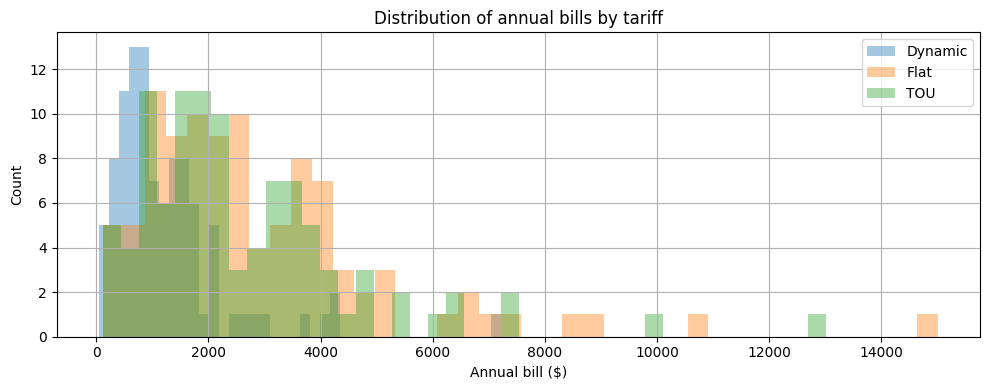

In [242]:
# Compare how annual bills are distributed across tariffs (flat, TOU, dynamic)

if bills_with_meta is not None:
    # Columns we expect from apply_all_tariffs / compute_bills_chunked
    expected_bill_cols = [
        "annual_cost_flat",
        "annual_cost_tou",
        "annual_cost_dynamic",
    ]
    bill_cols = [c for c in expected_bill_cols if c in bills_with_meta.columns]

    if not bill_cols:
        print("No annual_cost_* columns found; cannot plot bill distributions.")
    else:
        # Melt to long format: one row per (building, tariff)
        bills_long = bills_with_meta.melt(
            id_vars=["bldg_id", "annual_kwh"],
            value_vars=bill_cols,
            var_name="tariff",
            value_name="annual_cost",
        )

        # Optional: cleaner legend labels
        label_map = {
            "annual_cost_flat": "Flat",
            "annual_cost_tou": "TOU",
            "annual_cost_dynamic": "Dynamic",
        }

        plt.figure(figsize=(10, 4))
        for name, grp in bills_long.groupby("tariff"):
            label = label_map.get(name, name)
            grp["annual_cost"].hist(bins=40, alpha=0.4, label=label)
        plt.xlabel("Annual bill ($)")
        plt.ylabel("Count")
        plt.title("Distribution of annual bills by tariff")
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("bills_with_meta is None; cannot plot bill distributions.")

### Bills by income quantile (distributional fairness check)

Here we examine how annual bills under each tariff (flat, TOU, dynamic) vary across household income.
We bucket households into income quartiles and compare both:
- boxplots of bill distributions by income group, and  
- summary statistics (mean, std, min, max) for each tariff × income-quantile cell.


<Figure size 600x400 with 0 Axes>

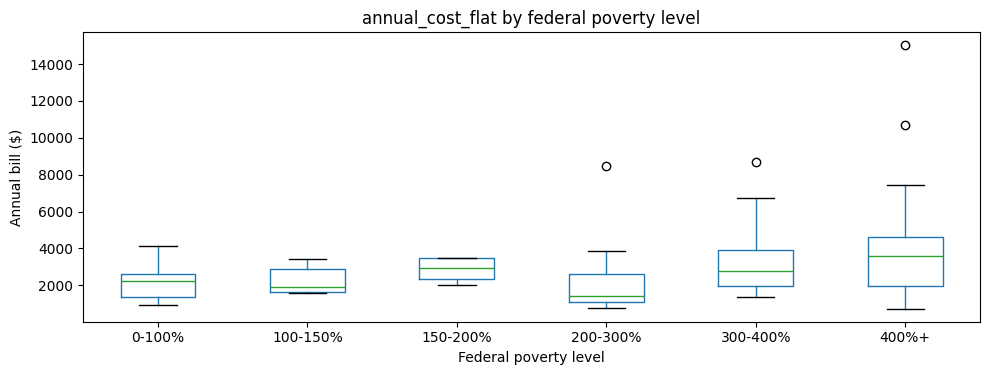

<Figure size 600x400 with 0 Axes>

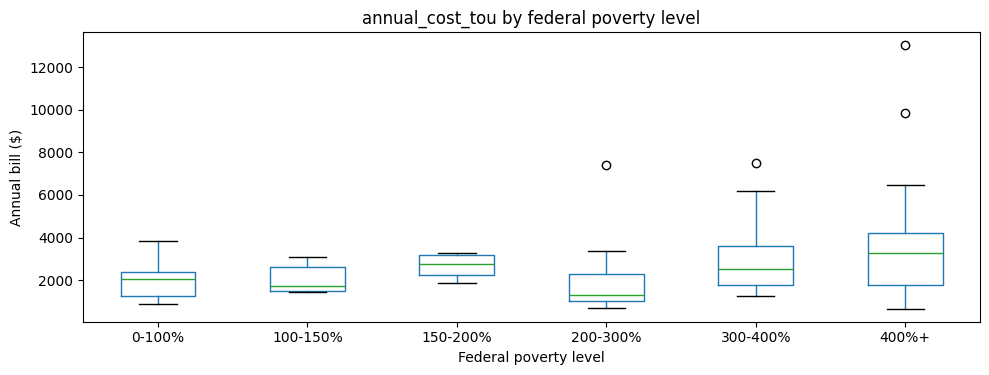

<Figure size 600x400 with 0 Axes>

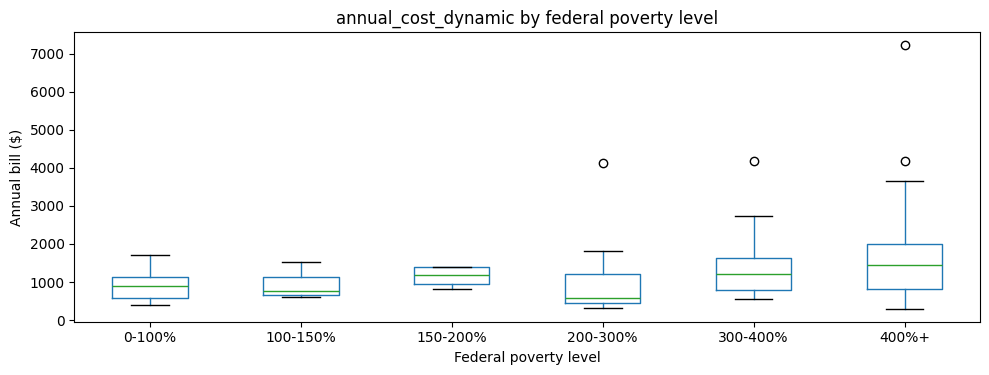

Summary of annual bills by income quantile:


,annual_cost_flat_mean,annual_cost_flat_std,annual_cost_flat_min,annual_cost_flat_max,annual_cost_tou_mean,annual_cost_tou_std,annual_cost_tou_min,annual_cost_tou_max,annual_cost_dynamic_mean,annual_cost_dynamic_std,annual_cost_dynamic_min,annual_cost_dynamic_max
in.federal_poverty_level,,,,,,,,,,,,
0-100%,2112.225672,979.075224,938.851963,4138.404798,1945.611723,909.532506,865.204453,3848.166469,882.200087,405.561068,397.934975,1717.288586
100-150%,2251.973229,824.857271,1561.589247,3407.174678,2041.730530,725.165958,1441.000790,3065.801757,920.060224,370.754660,613.366844,1518.113985
150-200%,2859.233070,740.618452,2022.167773,3487.228186,2663.497495,666.502285,1870.023279,3255.153786,1146.992295,296.263265,806.391049,1399.968175
200-300%,2306.667130,2019.824629,754.236414,8468.261059,2066.310657,1768.761573,707.572909,7410.581716,1013.708587,1003.604197,328.052117,4137.066941
300-400%,3436.231901,2157.121239,1352.518118,8696.200911,3106.963847,1885.914403,1231.138256,7482.524443,1461.782751,1009.465243,541.339524,4176.259630
400%+,3787.756661,2666.287915,739.633764,15009.706239,3437.484479,2353.759531,663.633665,13015.767983,1595.061845,1227.574240,302.673771,7210.608882


In [253]:
# Compare annual bills across income quartiles (distributional fairness)
if bills_with_meta is not None and "in.federal_poverty_level" in bills_with_meta.columns:
    # Work on a copy so we don't accidentally mess up the original frame too much
    df_inc = bills_with_meta.copy()

    mask = df_inc["in.federal_poverty_level"] != "Not Available"
    df_inc = df_inc[mask].copy()

    # Drop rows with missing income for quantile assignment
    df_inc = df_inc.dropna(subset=["in.federal_poverty_level"])

    if df_inc.empty:
        print("No non-missing income values; skipping income-based analysis.")
    else:
        # Define income quartiles (Q1 lowest, Q4 highest).
        # qcut can struggle if many incomes are identical; wrap in try/except.
        # List of tariff bill columns we expect
        bill_cols = ["annual_cost_flat", "annual_cost_tou", "annual_cost_dynamic"]
        bill_cols = [c for c in bill_cols if c in df_inc.columns]

        # --- Boxplots: annual bill by income bracket for each tariff ---
        for col in bill_cols:
            plt.figure(figsize=(6, 4))
            df_inc.boxplot(
                column=col,
                by="in.federal_poverty_level",
                grid=False,
            )
            plt.title(f"{col} by federal poverty level")
            plt.suptitle("")  # remove default pandas title
            plt.xlabel("Federal poverty level")
            plt.ylabel("Annual bill ($)")
            plt.tight_layout()
            plt.show()

        # --- Numeric summary: mean, std, min, max by income quantile ---
        summary = (
            df_inc.groupby("in.federal_poverty_level")[bill_cols]
            .agg(["mean", "std", "min", "max"])
        )

        # Flatten MultiIndex columns for easier reading
        summary.columns = [
            f"{tariff}_{stat}" for tariff, stat in summary.columns
        ]

        print("Summary of annual bills by income quantile:")
        display(summary)

This is the code for cost per kwh:

<Figure size 600x400 with 0 Axes>

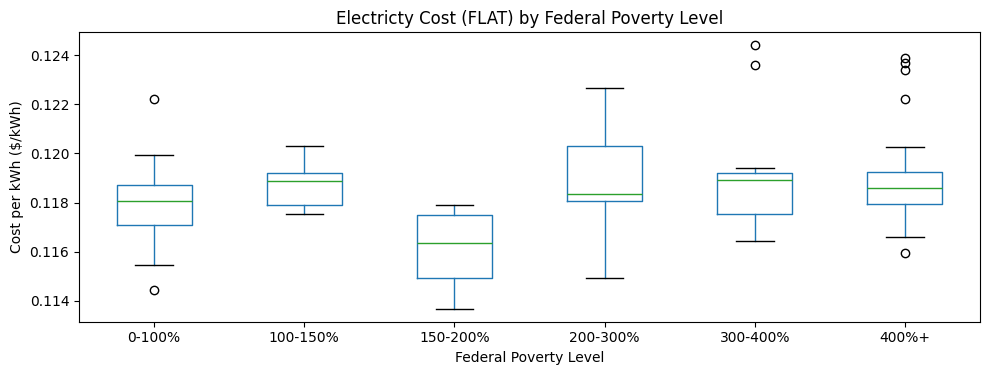

<Figure size 600x400 with 0 Axes>

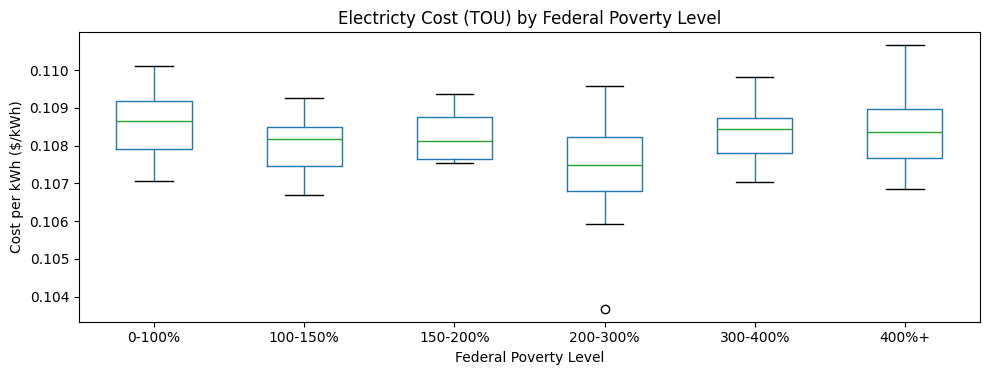

<Figure size 600x400 with 0 Axes>

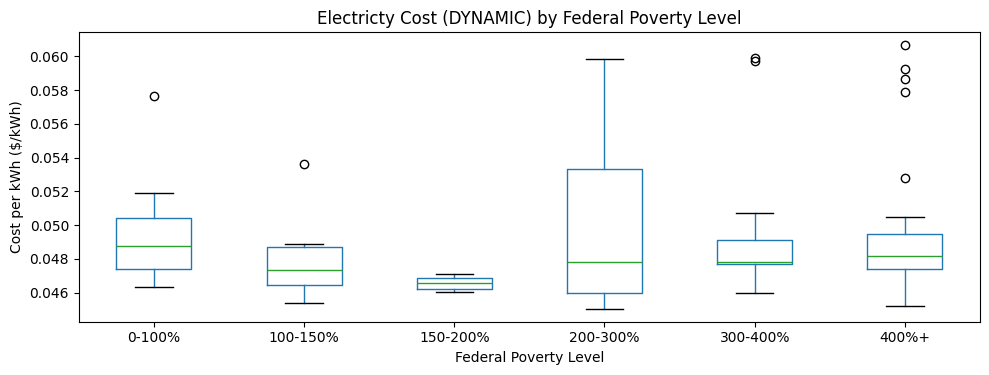

Summary of cost per kWh by federal_poverty_level:


,annual_cost_flat_per_kwh_per_kwh_mean,annual_cost_flat_per_kwh_per_kwh_std,annual_cost_flat_per_kwh_per_kwh_min,annual_cost_flat_per_kwh_per_kwh_max,annual_cost_tou_per_kwh_per_kwh_mean,annual_cost_tou_per_kwh_per_kwh_std,annual_cost_tou_per_kwh_per_kwh_min,annual_cost_tou_per_kwh_per_kwh_max,annual_cost_dynamic_per_kwh_per_kwh_mean,annual_cost_dynamic_per_kwh_per_kwh_std,annual_cost_dynamic_per_kwh_per_kwh_min,annual_cost_dynamic_per_kwh_per_kwh_max
in.federal_poverty_level,,,,,,,,,,,,
0-100%,0.117948,0.002093,0.114439,0.122213,0.108522,0.000922,0.107064,0.110117,0.049442,0.003225,0.046353,0.057636
100-150%,0.118747,0.001046,0.117549,0.120323,0.108015,0.000919,0.106683,0.109261,0.048161,0.002970,0.045355,0.053611
150-200%,0.116077,0.001939,0.113678,0.117893,0.108280,0.000848,0.107532,0.109359,0.046563,0.000498,0.046010,0.047123
200-300%,0.119011,0.002217,0.114932,0.122664,0.107371,0.001480,0.103683,0.109591,0.050234,0.005483,0.045051,0.059816
300-400%,0.119121,0.002376,0.116439,0.124401,0.108328,0.000854,0.107039,0.109812,0.049824,0.004565,0.045956,0.059887
400%+,0.118828,0.001731,0.115941,0.123878,0.108428,0.001026,0.106841,0.110651,0.049147,0.003542,0.045190,0.060639


In [260]:
# Make sure the consumption column exists
if "annual_kwh" in df_inc.columns:
    for col in bill_cols:
        df_inc[f"{col}_per_kwh"] = df_inc[col] / df_inc["annual_kwh"]

    # Now you can do the same summaries / boxplots but for $/kWh
    for col in bill_cols:
        plt.figure(figsize=(6, 4))
        df_inc.boxplot(
            column=f"{col}_per_kwh",
            by="in.federal_poverty_level",
            grid=False,
        )
        plt.title(f"Electricty Cost ({col.split("_")[-1].upper()}) by Federal Poverty Level")
        plt.suptitle("") # remove default pandas title
        plt.xlabel("Federal Poverty Level")
        plt.ylabel("Cost per kWh ($/kWh)")
        plt.tight_layout()
        plt.show()

    # Numeric summary
    summary_per_kwh = (
        df_inc.groupby("in.federal_poverty_level")[
            [f"{col}_per_kwh" for col in bill_cols]
        ]
        .agg(["mean", "std", "min", "max"])
    )
    summary_per_kwh.columns = [
        f"{tariff}_per_kwh_{stat}" for tariff, stat in summary_per_kwh.columns
    ]
    print("Summary of cost per kWh by federal_poverty_level:")
    display(summary_per_kwh)
else:
    print("Column 'annual_kwh' not found; cannot compute cost per kWh.")


### Tariff deltas: who wins or loses relative to flat?

Here we compute, for each household, the difference in annual bills under TOU and dynamic tariffs relative to a flat tariff.
We first look at the overall distribution of TOU–flat deltas, then (if income data is available) examine how these bill changes vary across income quartiles.


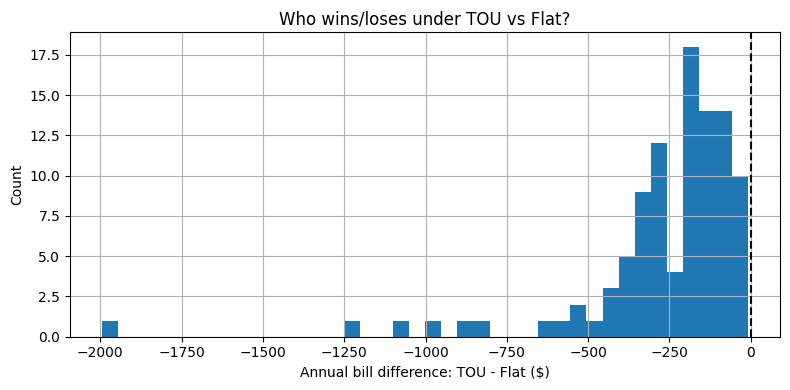

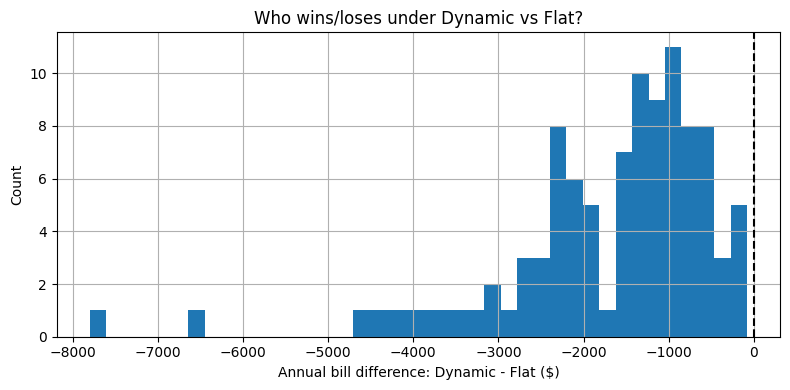

<Figure size 600x400 with 0 Axes>

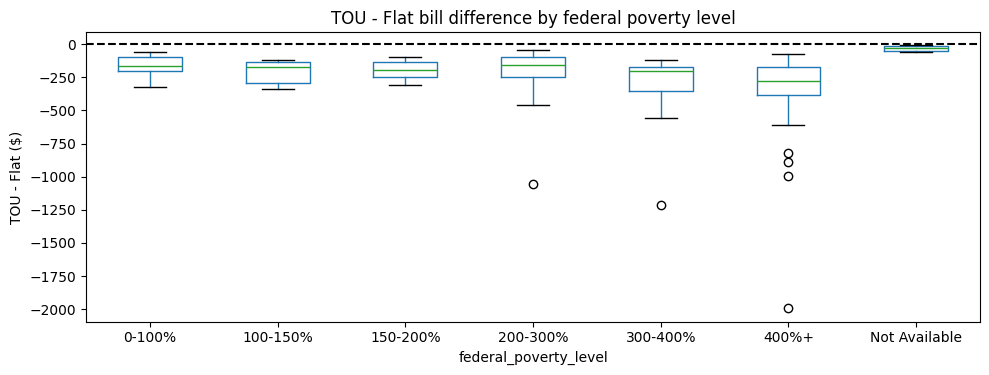

<Figure size 600x400 with 0 Axes>

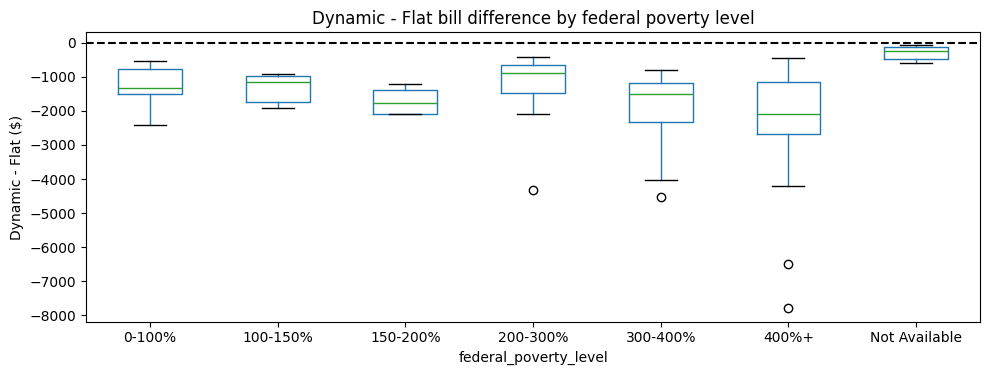

Summary of annual bill differences by federal poverty level:


,delta_tou_minus_flat_mean,delta_tou_minus_flat_median,delta_tou_minus_flat_std,delta_tou_minus_flat_min,delta_tou_minus_flat_max,delta_dynamic_minus_flat_mean,delta_dynamic_minus_flat_median,delta_dynamic_minus_flat_std,delta_dynamic_minus_flat_min,delta_dynamic_minus_flat_max
in.federal_poverty_level,,,,,,,,,,
0-100%,-166.613949,-166.184151,85.178699,-322.229994,-55.938486,-1230.025585,-1337.201186,579.327117,-2421.116211,-540.916988
100-150%,-210.242699,-172.603209,100.005838,-341.372921,-120.588457,-1331.913005,-1139.986178,462.779335,-1925.330978,-920.785747
150-200%,-195.735576,-192.109448,92.810010,-305.649294,-93.074114,-1712.240775,-1772.720946,444.471574,-2087.744485,-1215.776724
200-300%,-240.356473,-153.683181,261.004956,-1057.679343,-46.663505,-1292.958543,-876.116972,1025.151010,-4331.194118,-426.184297
300-400%,-329.268054,-202.871195,293.969111,-1213.676468,-121.379862,-1974.449150,-1494.067017,1166.194904,-4519.941281,-811.178593
400%+,-350.272182,-280.813395,332.524861,-1993.938256,-76.000099,-2192.694815,-2079.501621,1458.441250,-7799.097356,-436.959992
Not Available,-32.758368,-31.425858,20.594043,-60.587797,-9.366830,-296.752760,-236.115541,196.584286,-586.170054,-79.023767



Overall summary of annual bill differences (all households):


,delta_tou_minus_flat,delta_dynamic_minus_flat
mean,-268.791564,-1690.966330
median,-186.636891,-1379.376847
std,279.266409,1268.663148
min,-1993.938256,-7799.097356
max,-9.366830,-79.023767


In [268]:
# Compare annual bill differences (TOU vs Flat, Dynamic vs Flat)

if bills_with_meta is not None:
    df = bills_with_meta.copy()

    # Ensure the needed columns exist
    needed_cols = ["annual_cost_flat", "annual_cost_tou", "annual_cost_dynamic"]

    missing = [c for c in needed_cols if c not in df.columns]
    if missing:
        print("Missing bill columns, cannot compute deltas:", missing)
    else:
        # Compute deltas relative to flat
        df["delta_tou_minus_flat"] = df["annual_cost_tou"] - df["annual_cost_flat"]

        df["delta_dynamic_minus_flat"] = df["annual_cost_dynamic"] - df["annual_cost_flat"]

        # --- Overall histogram for TOU - Flat ---
        plt.figure(figsize=(8, 4))
        df["delta_tou_minus_flat"].hist(bins=40)
        plt.axvline(0, color="k", linestyle="--")
        plt.xlabel("Annual bill difference: TOU - Flat ($)")
        plt.ylabel("Count")
        plt.title("Who wins/loses under TOU vs Flat?")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 4))
        df["delta_dynamic_minus_flat"].hist(bins=40)
        plt.axvline(0, color="k", linestyle="--")
        plt.xlabel("Annual bill difference: Dynamic - Flat ($)")
        plt.ylabel("Count")
        plt.title("Who wins/loses under Dynamic vs Flat?")
        plt.tight_layout()
        plt.show()

        # --- Optional: difference by income quantile ---

        if "in.federal_poverty_level" in df.columns:
            plt.figure(figsize=(6, 4))
            df.boxplot(
                column="delta_tou_minus_flat",
                by="in.federal_poverty_level",
                grid=False,
            )
            plt.axhline(0, color="k", linestyle="--")
            plt.title("TOU - Flat bill difference by federal poverty level")
            plt.suptitle("")
            plt.xlabel("federal_poverty_level")
            plt.ylabel("TOU - Flat ($)")
            plt.tight_layout()
            plt.show()
        
        if "in.federal_poverty_level" in df.columns:
            plt.figure(figsize=(6, 4))
            df.boxplot(
                column="delta_dynamic_minus_flat",
                by="in.federal_poverty_level",
                grid=False,
            )
            plt.axhline(0, color="k", linestyle="--")
            plt.title("Dynamic - Flat bill difference by federal poverty level")
            plt.suptitle("")
            plt.xlabel("federal_poverty_level")
            plt.ylabel("Dynamic - Flat ($)")
            plt.tight_layout()
            plt.show()


    # If you have income groups, summarize by group
    if "in.federal_poverty_level" in df.columns:
        summary = (
            df.groupby("in.federal_poverty_level")[
                ["delta_tou_minus_flat", "delta_dynamic_minus_flat"]
            ]
            .agg(["mean", "median", "std", "min", "max"])
        )

        # Clean column names (optional)
        summary.columns = [
            f"{col}_{stat}"
            for col, stat in summary.columns
        ]

        print("Summary of annual bill differences by federal poverty level:")
        display(summary)

    # Also provide overall summary across all households
    overall_summary = df[
        ["delta_tou_minus_flat", "delta_dynamic_minus_flat"]
    ].agg(["mean", "median", "std", "min", "max"])

    print("\nOverall summary of annual bill differences (all households):")
    display(overall_summary)

    # If you want to keep the new columns in the global object:
    bills_with_meta["delta_tou_minus_flat"] = df["delta_tou_minus_flat"]
    bills_with_meta["delta_dynamic_minus_flat"] = df["delta_dynamic_minus_flat"]

This is the code for cost per kwh:

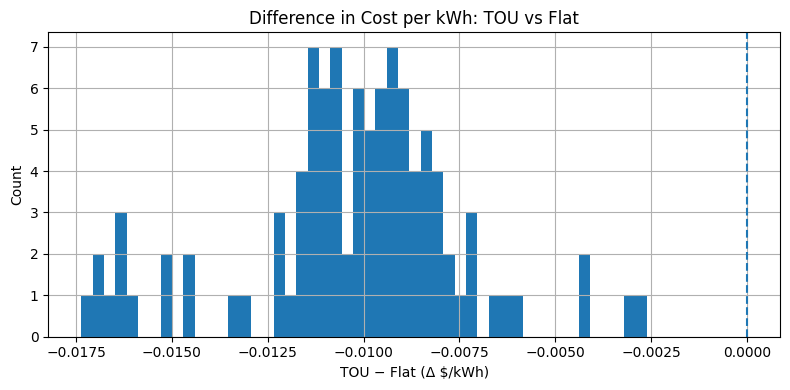

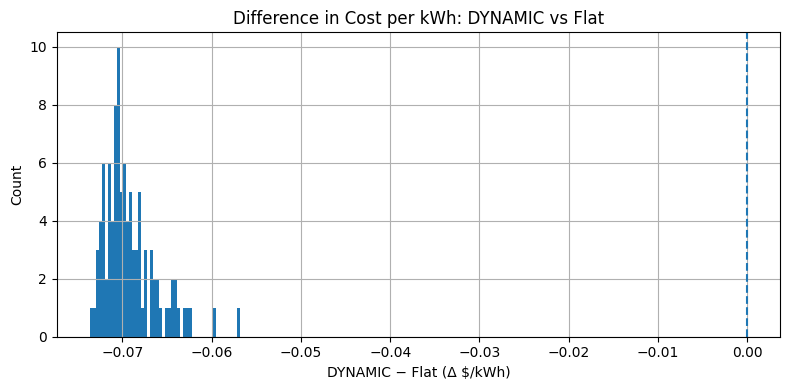

<Figure size 600x400 with 0 Axes>

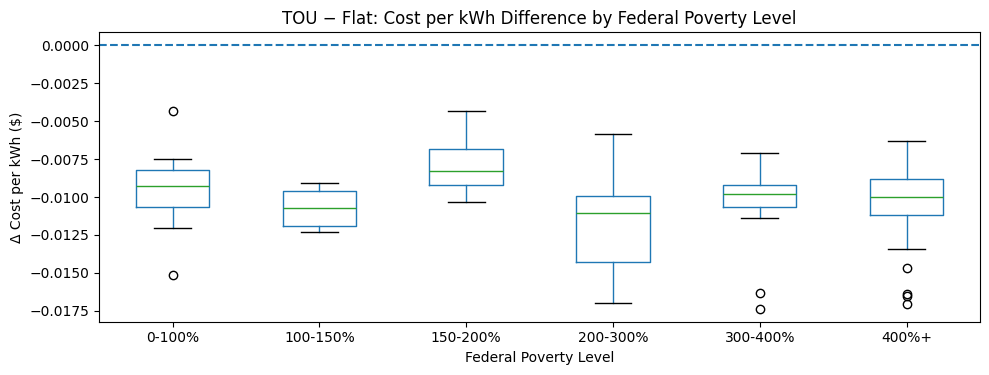

<Figure size 600x400 with 0 Axes>

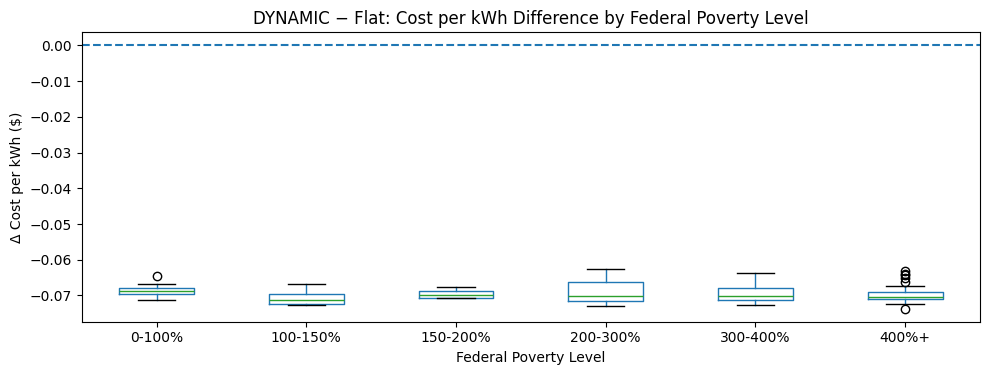

Summary of per-kWh differences by federal poverty level:


,delta_tou_per_kwh_mean,delta_tou_per_kwh_median,delta_tou_per_kwh_std,delta_tou_per_kwh_min,delta_tou_per_kwh_max,delta_dynamic_per_kwh_mean,delta_dynamic_per_kwh_median,delta_dynamic_per_kwh_std,delta_dynamic_per_kwh_min,delta_dynamic_per_kwh_max
in.federal_poverty_level,,,,,,,,,,
0-100%,-0.009426,-0.009263,0.002782,-0.015149,-0.004322,-0.068506,-0.068715,0.001787,-0.071175,-0.064578
100-150%,-0.010732,-0.010738,0.001378,-0.012281,-0.009084,-0.070586,-0.071289,0.002279,-0.072553,-0.066711
150-200%,-0.007797,-0.008254,0.002566,-0.010361,-0.004319,-0.069514,-0.069809,0.001452,-0.070770,-0.067668
200-300%,-0.011640,-0.011045,0.003223,-0.017004,-0.005862,-0.068777,-0.070191,0.003734,-0.072991,-0.062521
300-400%,-0.010793,-0.009771,0.002897,-0.017362,-0.007082,-0.069297,-0.070080,0.002836,-0.072778,-0.063711
400%+,-0.010400,-0.010010,0.002376,-0.017038,-0.006333,-0.069680,-0.070303,0.002276,-0.073664,-0.063062


In [ ]:
if bills_with_meta is not None:
    df = bills_with_meta.copy()

    needed_cols = ["annual_cost_flat", "annual_cost_tou", "annual_cost_dynamic", "annual_kwh"]
    missing = [c for c in needed_cols if c not in df.columns]

    if missing:
        print("Missing columns:", missing)
    else:
        df["flat_per_kwh"]     = df["annual_cost_flat"]     / df["annual_kwh"]
        df["tou_per_kwh"]      = df["annual_cost_tou"]      / df["annual_kwh"]
        df["dynamic_per_kwh"]  = df["annual_cost_dynamic"]  / df["annual_kwh"]

        df["delta_tou_per_kwh"]     = df["tou_per_kwh"]     - df["flat_per_kwh"]
        df["delta_dynamic_per_kwh"] = df["dynamic_per_kwh"] - df["flat_per_kwh"]

        delta_cols = ["delta_tou_per_kwh", "delta_dynamic_per_kwh"]


        for delta in delta_cols:
            plt.figure(figsize=(8, 4))
            df[delta].hist(bins=50)
            plt.axvline(0, linestyle="--")
            label = delta.replace("_per_kwh", "").replace("delta_", "").upper()
            plt.xlabel(f"{label} − Flat (Δ $/kWh)")
            plt.ylabel("Count")
            plt.title(f"Difference in Cost per kWh: {label} vs Flat")
            plt.tight_layout()
            plt.show()


        if "in.federal_poverty_level" in df.columns:

            # Drop "Not available" or equivalent
            group_clean = df["in.federal_poverty_level"] != "Not Available"
            df_clean = df[group_clean]

            for delta in delta_cols:
                plt.figure(figsize=(6, 4))
                df_clean.boxplot(
                    column=delta,
                    by="in.federal_poverty_level",
                    grid=False,
                )
                plt.axhline(0, linestyle="--")
                label = delta.replace("_per_kwh", "").replace("delta_", "").upper()
                plt.title(f"{label} − Flat: Cost per kWh Difference by Federal Poverty Level")
                plt.suptitle("")
                plt.xlabel("Federal Poverty Level")
                plt.ylabel("Δ Cost per kWh ($)")
                plt.tight_layout()
                plt.show()

        # ------------------------------------------------------
        # Step 5: Summary table (optional)
        # ------------------------------------------------------
        summary = (
            df_clean.groupby("in.federal_poverty_level")[delta_cols]
            .agg(["mean", "median", "std", "min", "max"])
        )
        summary.columns = [f"{col}_{stat}" for col, stat in summary.columns]

        print("Summary of per-kWh differences by federal poverty level:")
        display(summary)

        # Optionally store back into main object
        bills_with_meta["delta_tou_per_kwh"]     = df["delta_tou_per_kwh"]
        bills_with_meta["delta_dynamic_per_kwh"] = df["delta_dynamic_per_kwh"]


### Progressivity Index:
Annual Cost= α + β⋅Income

A larger positive slope means costs rise more steeply with income.
A smaller slope means the rate structure is less progressive, because the increase in cost across income groups is flatter. Dynamic pricing compresses annual cost differences across income levels the most, making it the least progressive structure, while flat pricing maintains the steepest increase in cost with income and is therefore the most progressive Lower-income groups see smaller discounts from TOU and dynamic. Higher-income groups see larger discounts, flattening the cost–income gradient.

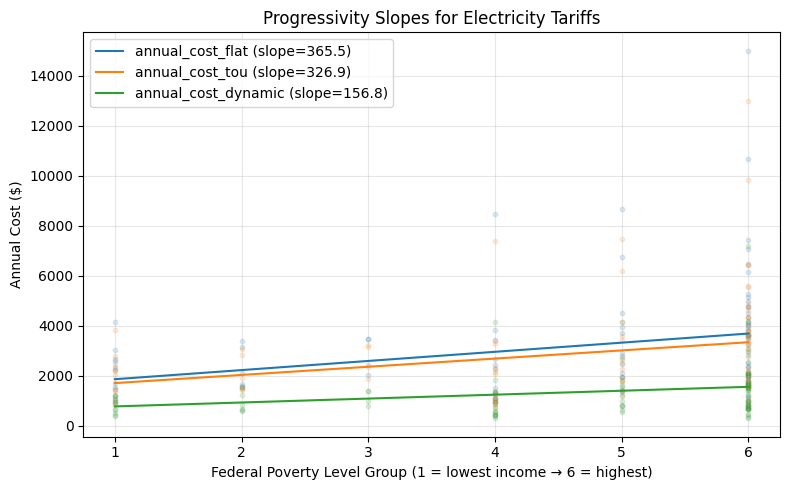

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# x-values (FPL group numbers)
x = df_inc["fpl_group_num"]

plt.figure(figsize=(8,5))

for col in bill_cols:
    y = df_inc[col]

    # compute slope + intercept
    slope, intercept = np.polyfit(x, y, 1)

    # scatter points
    plt.scatter(x, y, alpha=0.15, s=10)

    # fitted line
    x_line = np.array([1, 6])
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, label=f"{col} (slope={slope:.1f})")

plt.xlabel("Federal Poverty Level Group (1 = lowest income → 6 = highest)")
plt.ylabel("Annual Cost ($)")
plt.title("Progressivity Slopes for Electricity Tariffs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
